# Mechanics of forecasting

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/17-mechanics-of-forecasting.ipynb)

This notebook uncovers the details of forecasting by pipelines in ETNA library. We are going to explain how pipelines are dealing with dataset, transforms and models to make a prediction.

**Table of contents**

* [Loading dataset](#chapter1)
* [Forecasting](#chapter2)
    * [Context-free models](#section_2_1)
    * [Context-required models](#section_2_2)
    * [ML models](#section_2_3)

In [1]:
!pip install "etna[prophet]" -q

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd

from etna.datasets import TSDataset

## 1. Loading dataset <a class="anchor" id="chapter1"></a>

Let's load and look at the dataset

In [4]:
df = pd.read_csv("data/example_dataset.csv")
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


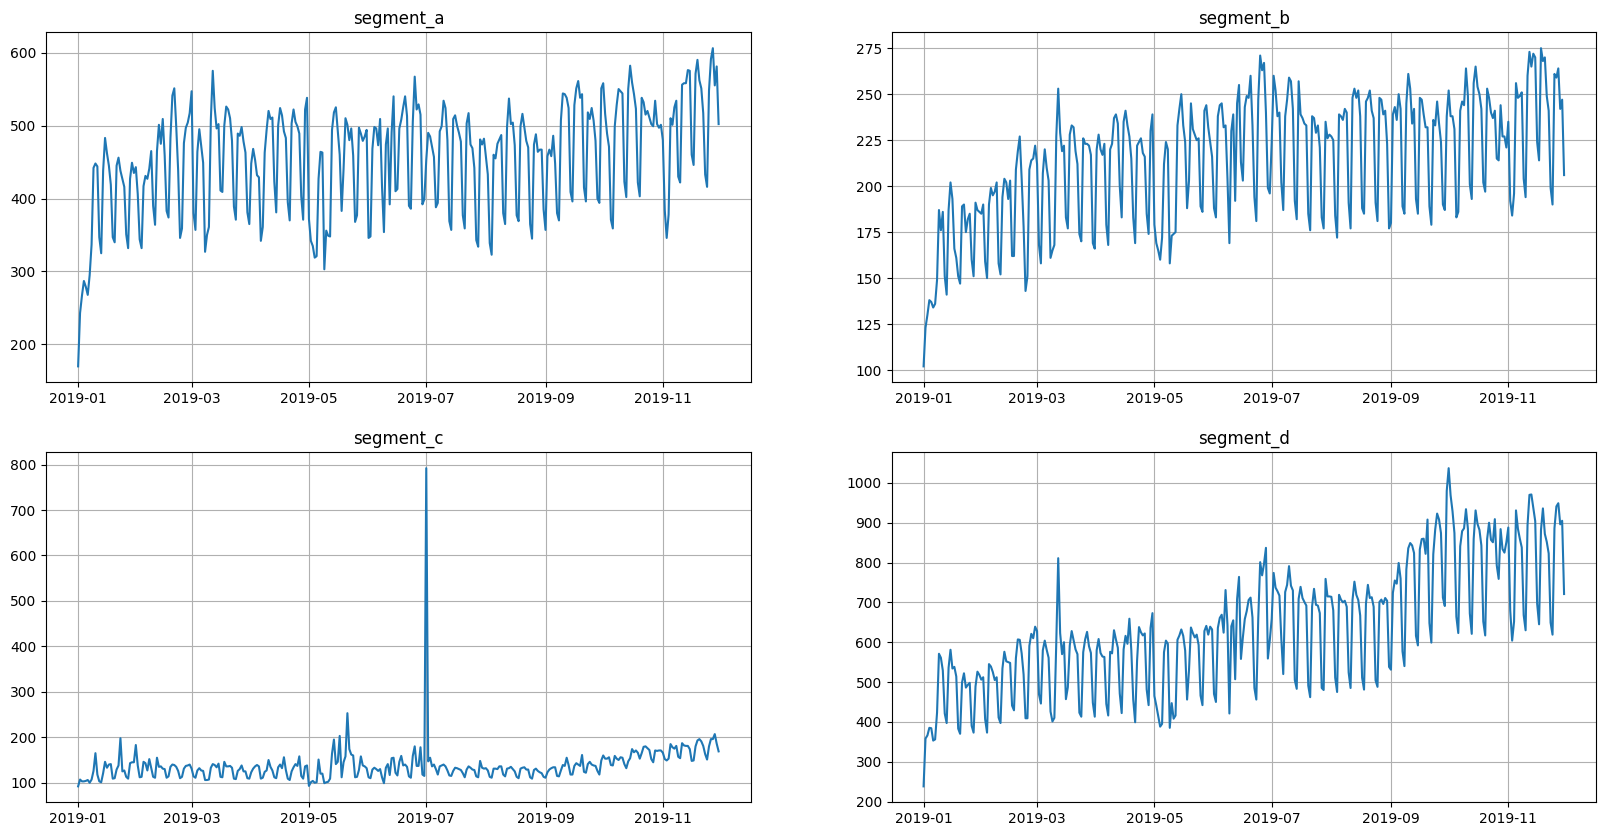

In [5]:
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")
ts.plot()

## 2. Forecasting <a class="anchor" id="chapter2"></a>

Now let's dive deeper into forecasting without pipelines. We are going to use only `TSDataset`, transforms and models.

In [6]:
HORIZON = 14

In [7]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

In [8]:
test_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-11-17    2019-11-30      14            0
segment_b      2019-11-17    2019-11-30      14            0
segment_c      2019-11-17    2019-11-30      14            0
segment_d      2019-11-17    2019-11-30      14            0


### 3.1 Context-free models <a class="anchor" id="section_2_1"></a>

Let's start by using the `ProphetModel`, because it doesn't require any transformations and doesn't need any context.

Fitting the model is very easy

In [9]:
from etna.models import ProphetModel

model = ProphetModel()
model.fit(train_ts)

14:35:52 - cmdstanpy - INFO - Chain [1] start processing
14:35:52 - cmdstanpy - INFO - Chain [1] done processing
14:35:52 - cmdstanpy - INFO - Chain [1] start processing
14:35:53 - cmdstanpy - INFO - Chain [1] done processing
14:35:53 - cmdstanpy - INFO - Chain [1] start processing
14:35:53 - cmdstanpy - INFO - Chain [1] done processing
14:35:53 - cmdstanpy - INFO - Chain [1] start processing
14:35:53 - cmdstanpy - INFO - Chain [1] done processing


ProphetModel(growth = 'linear', changepoints = None, n_changepoints = 25, changepoint_range = 0.8, yearly_seasonality = 'auto', weekly_seasonality = 'auto', daily_seasonality = 'auto', holidays = None, seasonality_mode = 'additive', seasonality_prior_scale = 10.0, holidays_prior_scale = 10.0, changepoint_prior_scale = 0.05, mcmc_samples = 0, interval_width = 0.8, uncertainty_samples = 1000, stan_backend = None, additional_seasonality_params = (), )

To make a forecast we should create a dataset with future data by using `make_future` method. We are currently interested in only `future_steps` parameter, it determines how many timestamps should be created after the end of the history.

As a result we would have a dataset with `future_steps` timestamps.

In [10]:
future_ts = train_ts.make_future(future_steps=HORIZON)
future_ts.to_pandas()

/Users/d.a.binin/Documents/tasks/etna-github/etna/datasets/tsdataset.py:281: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-11-17,NaN,NaN,NaN,NaN
2019-11-18,NaN,NaN,NaN,NaN
2019-11-19,NaN,NaN,NaN,NaN
2019-11-20,NaN,NaN,NaN,NaN
2019-11-21,NaN,NaN,NaN,NaN
2019-11-22,NaN,NaN,NaN,NaN
2019-11-23,NaN,NaN,NaN,NaN
2019-11-24,NaN,NaN,NaN,NaN


Now we are ready to make a forecast

In [11]:
forecast_ts = model.forecast(future_ts)
forecast_ts.to_pandas()

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-11-17,415.300214,196.610084,143.769761,723.287233
2019-11-18,528.270723,248.186730,181.336869,900.630429
2019-11-19,544.854787,253.049163,173.502291,938.072558
2019-11-20,535.458739,248.527842,169.407795,921.954696
2019-11-21,528.720640,244.837321,169.601296,916.216922
2019-11-22,516.531192,240.322263,168.009967,906.355884
2019-11-23,429.297574,203.910951,147.698344,759.476794
2019-11-24,417.935844,197.126646,146.009019,735.950357


We should note that `forecast_ts` isn't a new dataset, it is the same object as `future_ts`, but filled with predicted values

In [12]:
forecast_ts is future_ts

True

Now let's look at a metric and plot the prediction.

In [13]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_a': 6.179808820305944,
 'segment_c': 9.107343268713644,
 'segment_b': 4.162295213860478,
 'segment_d': 6.197016763401841}

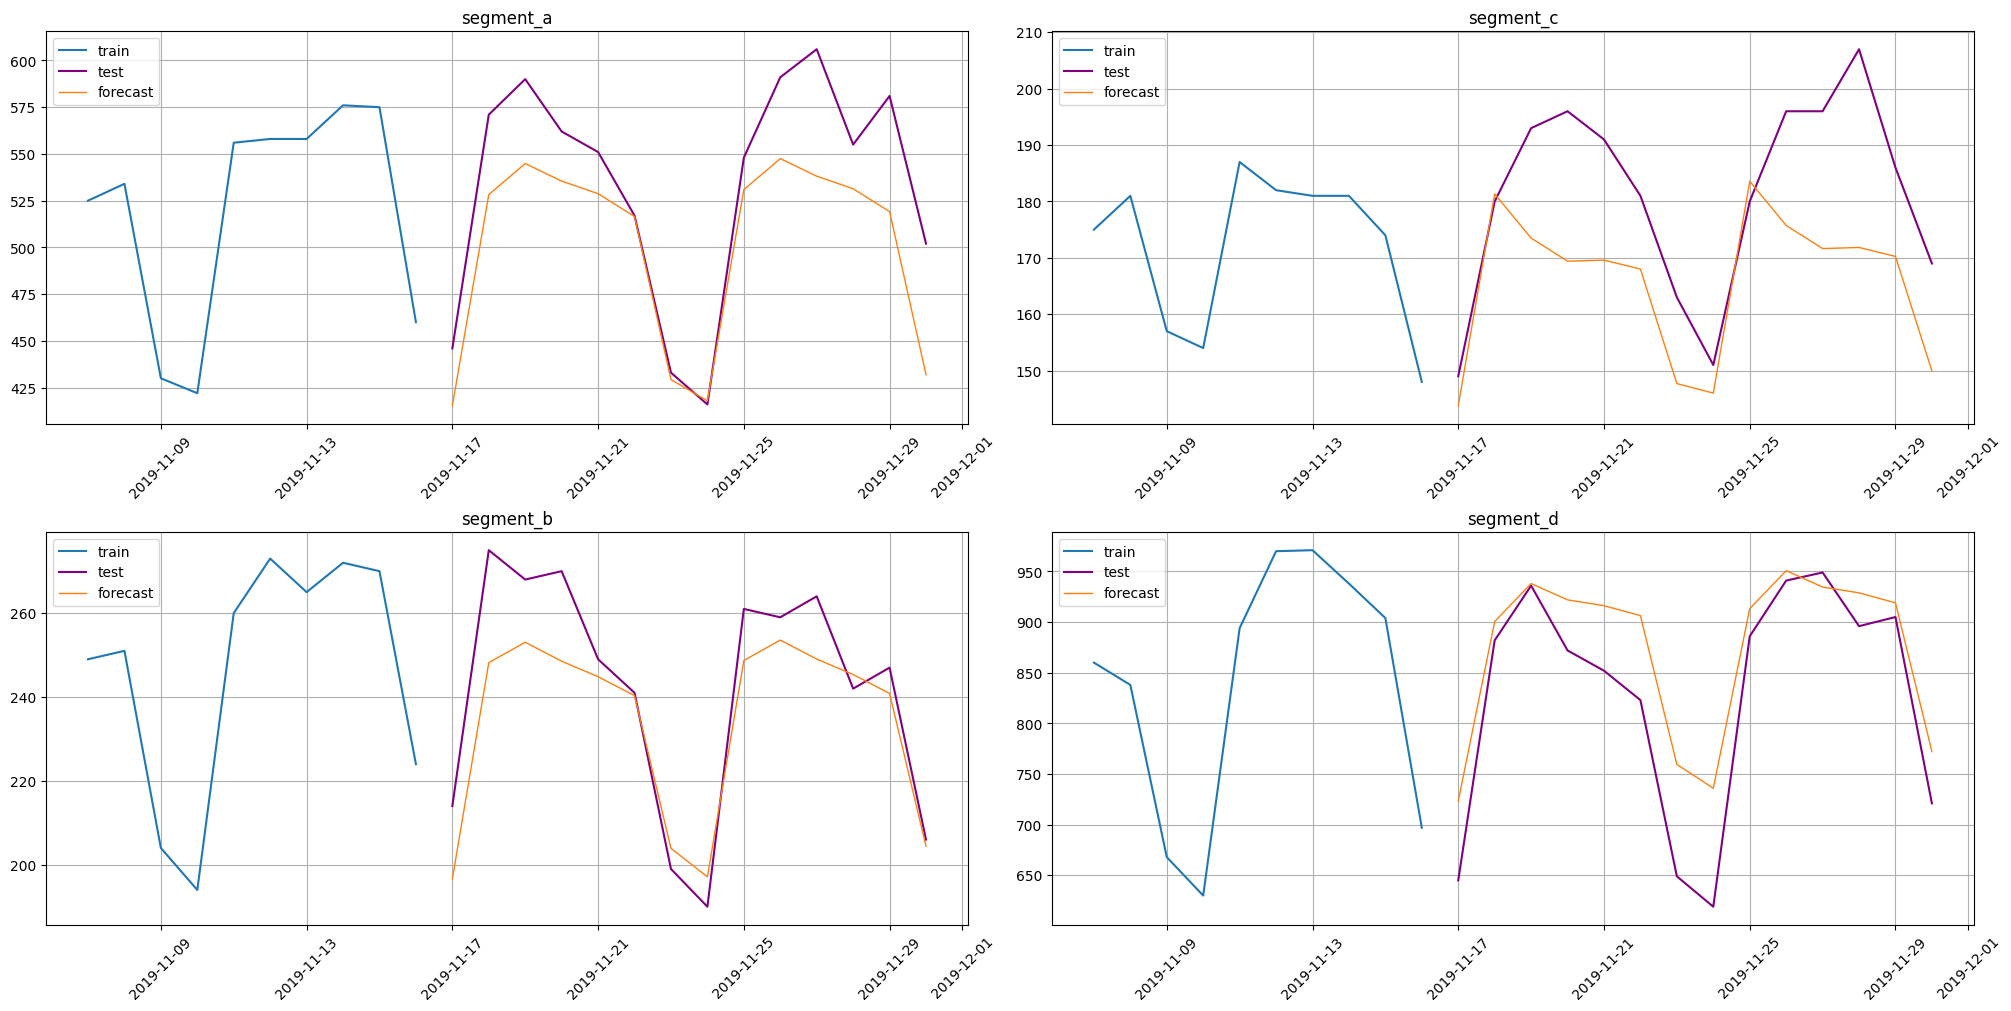

In [14]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 3.2 Context-required models <a class="anchor" id="section_2_2"></a>

First of all, let's clarify that context is. The context is a history data the precedes the forecasting horizon.

And now let's expand our scheme to models that require some history context for forecasting. The example is `NaiveModel`, because it needs to know the value `lag` steps ago.

The fitting doesn't change

In [15]:
from etna.models import NaiveModel

model = NaiveModel(lag=14)
model.fit(train_ts)

NaiveModel(lag = 14, )

The models has `context_size` attribute that in this particular case is equal to `lag`

In [16]:
model.context_size

14

Future generation now needs a new parameter: `tail_steps`, it determines how many timestamps should be created before the end of the history.

The result will contain `future_steps + tail_step` timestamps.

In [17]:
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model.context_size)
future_ts.to_pandas()

/Users/d.a.binin/Documents/tasks/etna-github/etna/datasets/tsdataset.py:281: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-11-03,346.0,184.0,149.0,604.0
2019-11-04,378.0,196.0,153.0,652.0
2019-11-05,510.0,256.0,185.0,931.0
2019-11-06,501.0,248.0,178.0,885.0
2019-11-07,525.0,249.0,175.0,860.0
2019-11-08,534.0,251.0,181.0,838.0
2019-11-09,430.0,204.0,157.0,668.0
2019-11-10,422.0,194.0,154.0,630.0


Forecasting is slightly changed too. We need to pass `prediction_size` parameter that determines how many timestamps we want to see in our result.

In [18]:
forecast_ts = model.forecast(future_ts, prediction_size=HORIZON)
forecast_ts.to_pandas()

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-11-17,346.0,184.0,149.0,604.0
2019-11-18,378.0,196.0,153.0,652.0
2019-11-19,510.0,256.0,185.0,931.0
2019-11-20,501.0,248.0,178.0,885.0
2019-11-21,525.0,249.0,175.0,860.0
2019-11-22,534.0,251.0,181.0,838.0
2019-11-23,430.0,204.0,157.0,668.0
2019-11-24,422.0,194.0,154.0,630.0


The `forecast_ts` and `future_ts` are still the same object

In [19]:
forecast_ts is future_ts

True

The result of forecasting

In [20]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_a': 9.362036158596007,
 'segment_c': 6.930906591160424,
 'segment_b': 7.520927594702097,
 'segment_d': 4.304033333591803}

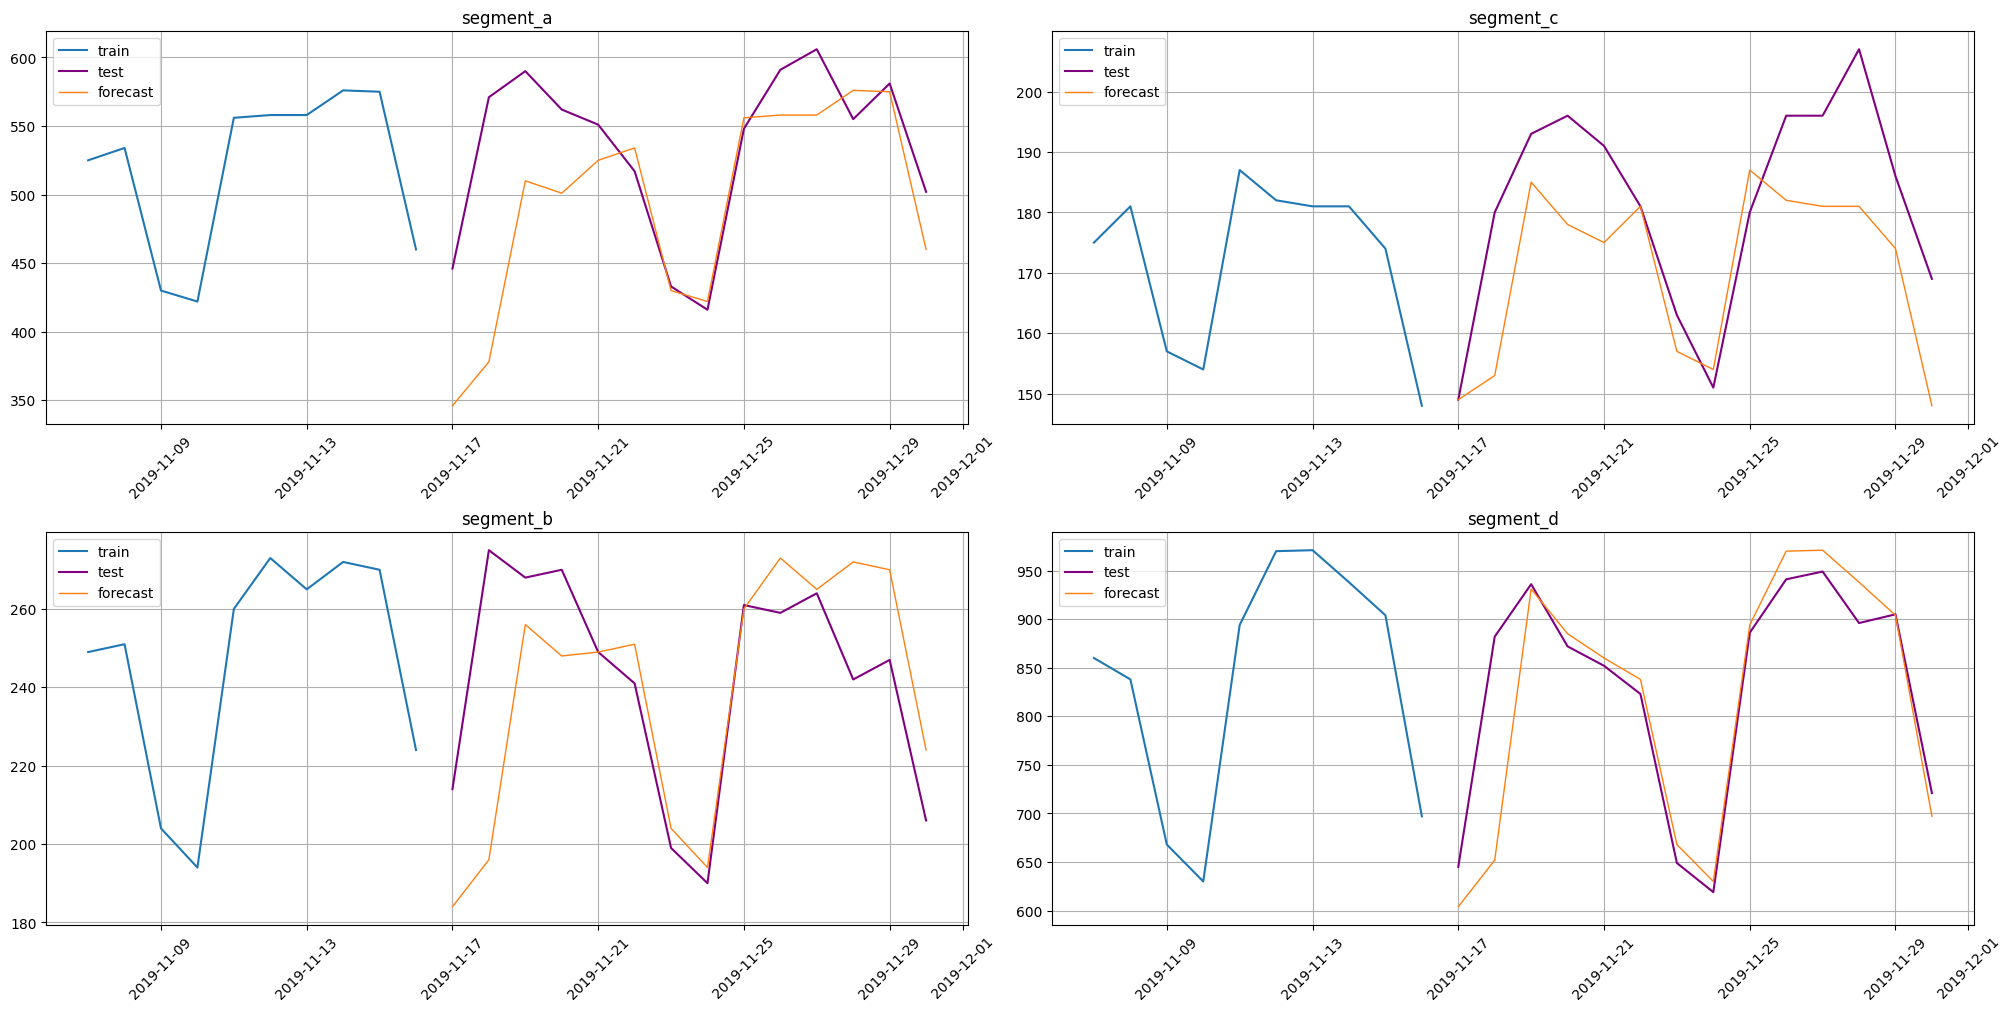

In [21]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 3.3 ML models <a class="anchor" id="section_2_3"></a>

Now we are going to expand our scheme even further by using transformations.

Let's define the transformations

In [22]:
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LogTransform
from etna.transforms import SegmentEncoderTransform

log = LogTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON + 3)), out_column="lag")
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=False,
    week_number_in_month=False,
    is_weekend=False,
    out_column="date_flag",
)
transforms = [log, lags, date_flags, seg]

Fitting the models requires the transfomations to be applied to the dataset

In [23]:
train_ts.to_pandas()

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384
...,...,...,...,...
2019-11-12,558,273,182,970
2019-11-13,558,265,181,971


In [24]:
train_ts.fit_transform(transforms)
train_ts.to_pandas()

segment                       segment_a                                \
feature    date_flag_day_number_in_week    lag_14    lag_15    lag_16   
timestamp                                                               
2019-01-01                            1       NaN       NaN       NaN   
2019-01-02                            2       NaN       NaN       NaN   
2019-01-03                            3       NaN       NaN       NaN   
2019-01-04                            4       NaN       NaN       NaN   
2019-01-05                            5       NaN       NaN       NaN   
...                                 ...       ...       ...       ...   
2019-11-12                            1  2.701568  2.728354  2.698970   
2019-11-13                            2  2.697229  2.701568  2.728354   
2019-11-14                            3  2.700704  2.697229  2.701568   
2019-11-15                            4  2.682145  2.700704  2.697229   
2019-11-16                            5  2.585461  2.682145  2.700704   

segment                                                          \
feature       lag_17    lag_18    lag_19 segment_code    target   
timestamp                                                         
2019-01-01       NaN       NaN       NaN            0  2.232996   
2019-01-02       NaN       NaN       NaN            0  2.387390   
2019-01-03       NaN       NaN       NaN            0  2.428135   
2019-01-04       NaN       NaN       NaN            0  2.459392   
2019-01-05       NaN       NaN       NaN            0  2.447158   
...              ...       ...       ...          ...       ...   
2019-11-12  2.701568  2.709270  2.716838            0  2.747412   
2019-11-13  2.698970  2.701568  2.709270            0  2.747412   
2019-11-14  2.728354  2.698970  2.701568            0  2.761176   
2019-11-15  2.701568  2.728354  2.698970            0  2.760422   
2019-11-16  2.697229  2.701568  2.728354            0  2.663701   

segment                       segment_b  ... segment_c  \
feature    date_flag_day_number_in_week  ...    target   
timestamp                                ...             
2019-01-01                            1  ...  1.968483   
2019-01-02                            2  ...  2.033424   
2019-01-03                            3  ...  2.017033   
2019-01-04                            4  ...  2.017033   
2019-01-05                            5  ...  2.021189   
...                                 ...  ...       ...   
2019-11-12                            1  ...  2.262451   
2019-11-13                            2  ...  2.260071   
2019-11-14                            3  ...  2.260071   
2019-11-15                            4  ...  2.243038   
2019-11-16                            5  ...  2.173186   

segment                       segment_d                                \
feature    date_flag_day_number_in_week    lag_14    lag_15    lag_16   
timestamp                                                               
2019-01-01                            1       NaN       NaN       NaN   
2019-01-02                            2       NaN       NaN       NaN   
2019-01-03                            3       NaN       NaN       NaN   
2019-01-04                            4       NaN       NaN       NaN   
2019-01-05                            5       NaN       NaN       NaN   
...                                 ...       ...       ...       ...   
2019-11-12                            1  2.921686  2.946943  2.880814   
2019-11-13                            2  2.916980  2.921686  2.946943   
2019-11-14                            3  2.930440  2.916980  2.921686   
2019-11-15                            4  2.948902  2.930440  2.916980   
2019-11-16                            5  2.833147  2.948902  2.930440   

segment                                                          
feature       lag_17    lag_18    lag_19 segment_code    target  
timestamp                                                        
2019

As you can see, there are several changes made by the transforms:
- Added `date_flag_day_number_in_week` column;
- Added `lag_14`, ..., `lag_19` columns;
- Added `segment_code` column;
- Logarithm applied to `target` column.

Now we are ready to fit our model

In [25]:
from etna.models import CatBoostMultiSegmentModel

model = CatBoostMultiSegmentModel()
model.fit(train_ts)

CatBoostMultiSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, )

In this case preparing future doesn't require dealing with the context, all the necessary information is in the features. But we have to deal with transformations by passing them into `make_future` method.

In [26]:
future_ts = train_ts.make_future(future_steps=HORIZON, transforms=transforms)

/Users/d.a.binin/Documents/tasks/etna-github/etna/datasets/tsdataset.py:281: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


Making a forecast

In [27]:
forecast_ts = model.forecast(future_ts)
forecast_ts.to_pandas()

segment                       segment_a                                \
feature    date_flag_day_number_in_week    lag_14    lag_15    lag_16   
timestamp                                                               
2019-11-17                            6  2.540329  2.585461  2.682145   
2019-11-18                            0  2.578639  2.540329  2.585461   
2019-11-19                            1  2.708421  2.578639  2.540329   
2019-11-20                            2  2.700704  2.708421  2.578639   
2019-11-21                            3  2.720986  2.700704  2.708421   
2019-11-22                            4  2.728354  2.720986  2.700704   
2019-11-23                            5  2.634477  2.728354  2.720986   
2019-11-24                            6  2.626340  2.634477  2.728354   
2019-11-25                            0  2.745855  2.626340  2.634477   
2019-11-26                            1  2.747412  2.745855  2.626340   
2019-11-27                            2  2.747412  2.747412  2.745855   
2019-11-28                            3  2.761176  2.747412  2.747412   
2019-11-29                            4  2.760422  2.761176  2.747412   
2019-11-30                            5  2.663701  2.760422  2.761176   

segment                                                          \
feature       lag_17    lag_18    lag_19 segment_code    target   
timestamp                                                         
2019-11-17  2.700704  2.697229  2.701568            0  2.565244   
2019-11-18  2.682145  2.700704  2.697229            0  2.635423   
2019-11-19  2.585461  2.682145  2.700704            0  2.693657   
2019-11-20  2.540329  2.585461  2.682145            0  2.694304   
2019-11-21  2.578639  2.540329  2.585461            0  2.690419   
2019-11-22  2.708421  2.578639  2.540329            0  2.686515   
2019-11-23  2.700704  2.708421  2.578639            0  2.618320   
2019-11-24  2.720986  2.700704  2.708421            0  2.598720   
2019-11-25  2.728354  2.720986  2.700704            0  2.719579   
2019-11-26  2.634477  2.728354  2.720986            0  2.738940   
2019-11-27  2.626340  2.634477  2.728354            0  2.724032   
2019-11-28  2.745855  2.626340  2.634477            0  2.716048   
2019-11-29  2.747412  2.745855  2.626340            0  2.727584   
2019-11-30  2.747412  2.747412  2.745855            0  2.653289   

segment                       segment_b  ... segment_c  \
feature    date_flag_day_number_in_week  ...    target   
timestamp                                ...             
2019-11-17                            6  ...  2.180748   
2019-11-18                            0  ...  2.231397   
2019-11-19                            1  ...  2.273559   
2019-11-20                            2  ...  2.270602   
2019-11-21                            3  ...  2.266112   
2019-11-22                            4  ...  2.247440   
2019-11-23                            5  ...  2.203895   
2019-11-24                            6  ...  2.183810   
2019-11-25                            0  ...  2.274007   
2019-11-26                            1  ...  2.285334   
2019-11-27                            2  ...  2.275239   
2019-11-28                            3  ...  2.270715   
2019-11-29                            4  ...  2.253787   
2019-11-30                            5  ...  2.197342   

segment                       segment_d                                \
feature    date_flag_day_number_in_week    lag_14    lag_15    lag_16   
timestamp                                                               
2019-11-17                            6  2.781755  2.833147  2.948902   
2019-11-18                            0  2.814913  2.781755  2.833147   
2019-11-19                            1  2.969416  2.814913  2.781755   
2019-11-20                            2  2.947434  2.969416  2.814913   
2019-11-21                            3  2.935003  2.947434  2.969416   
2019-11-22                            4  2.9237

The forecasted values are too small because we forecasted the target after the logarithm transformation. To get the predictions in original domain we should apply inverse transformation to the predicted values.

In [28]:
forecast_ts.inverse_transform(transforms)
forecast_ts.to_pandas()

segment                       segment_a                                \
feature    date_flag_day_number_in_week    lag_14    lag_15    lag_16   
timestamp                                                               
2019-11-17                            6  2.540329  2.585461  2.682145   
2019-11-18                            0  2.578639  2.540329  2.585461   
2019-11-19                            1  2.708421  2.578639  2.540329   
2019-11-20                            2  2.700704  2.708421  2.578639   
2019-11-21                            3  2.720986  2.700704  2.708421   
2019-11-22                            4  2.728354  2.720986  2.700704   
2019-11-23                            5  2.634477  2.728354  2.720986   
2019-11-24                            6  2.626340  2.634477  2.728354   
2019-11-25                            0  2.745855  2.626340  2.634477   
2019-11-26                            1  2.747412  2.745855  2.626340   
2019-11-27                            2  2.747412  2.747412  2.745855   
2019-11-28                            3  2.761176  2.747412  2.747412   
2019-11-29                            4  2.760422  2.761176  2.747412   
2019-11-30                            5  2.663701  2.760422  2.761176   

segment                                                            \
feature       lag_17    lag_18    lag_19 segment_code      target   
timestamp                                                           
2019-11-17  2.700704  2.697229  2.701568            0  366.488976   
2019-11-18  2.682145  2.700704  2.697229            0  430.939286   
2019-11-19  2.585461  2.682145  2.700704            0  492.920033   
2019-11-20  2.540329  2.585461  2.682145            0  493.656444   
2019-11-21  2.578639  2.540329  2.585461            0  489.251630   
2019-11-22  2.708421  2.578639  2.540329            0  484.864529   
2019-11-23  2.700704  2.708421  2.578639            0  414.259742   
2019-11-24  2.720986  2.700704  2.708421            0  395.935280   
2019-11-25  2.728354  2.720986  2.700704            0  523.298761   
2019-11-26  2.634477  2.728354  2.720986            0  547.201481   
2019-11-27  2.626340  2.634477  2.728354            0  528.702754   
2019-11-28  2.745855  2.626340  2.634477            0  519.053314   
2019-11-29  2.747412  2.745855  2.626340            0  533.052802   
2019-11-30  2.747412  2.747412  2.745855            0  449.079339   

segment                       segment_b  ...   segment_c  \
feature    date_flag_day_number_in_week  ...      target   
timestamp                                ...               
2019-11-17                            6  ...  150.617020   
2019-11-18                            0  ...  169.371644   
2019-11-19                            1  ...  186.740859   
2019-11-20                            2  ...  185.467185   
2019-11-21                            3  ...  183.548982   
2019-11-22                            4  ...  175.782834   
2019-11-23                            5  ...  158.917091   
2019-11-24                            6  ...  151.689824   
2019-11-25                            0  ...  186.934674   
2019-11-26                            1  ...  191.900794   
2019-11-27                            2  ...  187.468603   
2019-11-28                            3  ...  185.515565   
2019-11-29                            4  ...  178.385527   
2019-11-30                            5  ...  156.522153   

segment                       segment_d                                \
feature    date_flag_day_number_in_week    lag_14    lag_15    lag_16   
timestamp                                                               
2019-11-17                            6  2.781755  2.833147  2.948902   
2019-11-18                            0  2.814913  2.781755  2.833147   
2019-11-19                            1  2.969416  2.814913  2.781755   
2019-11-20                            2  2.947434  2.969416  2.814913   
2019-11-21                            3  2.935003  2

The result of forecasting

In [29]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_a': 11.31587889430999,
 'segment_c': 4.215269132207348,
 'segment_b': 8.81547034277906,
 'segment_d': 4.969009090222787}

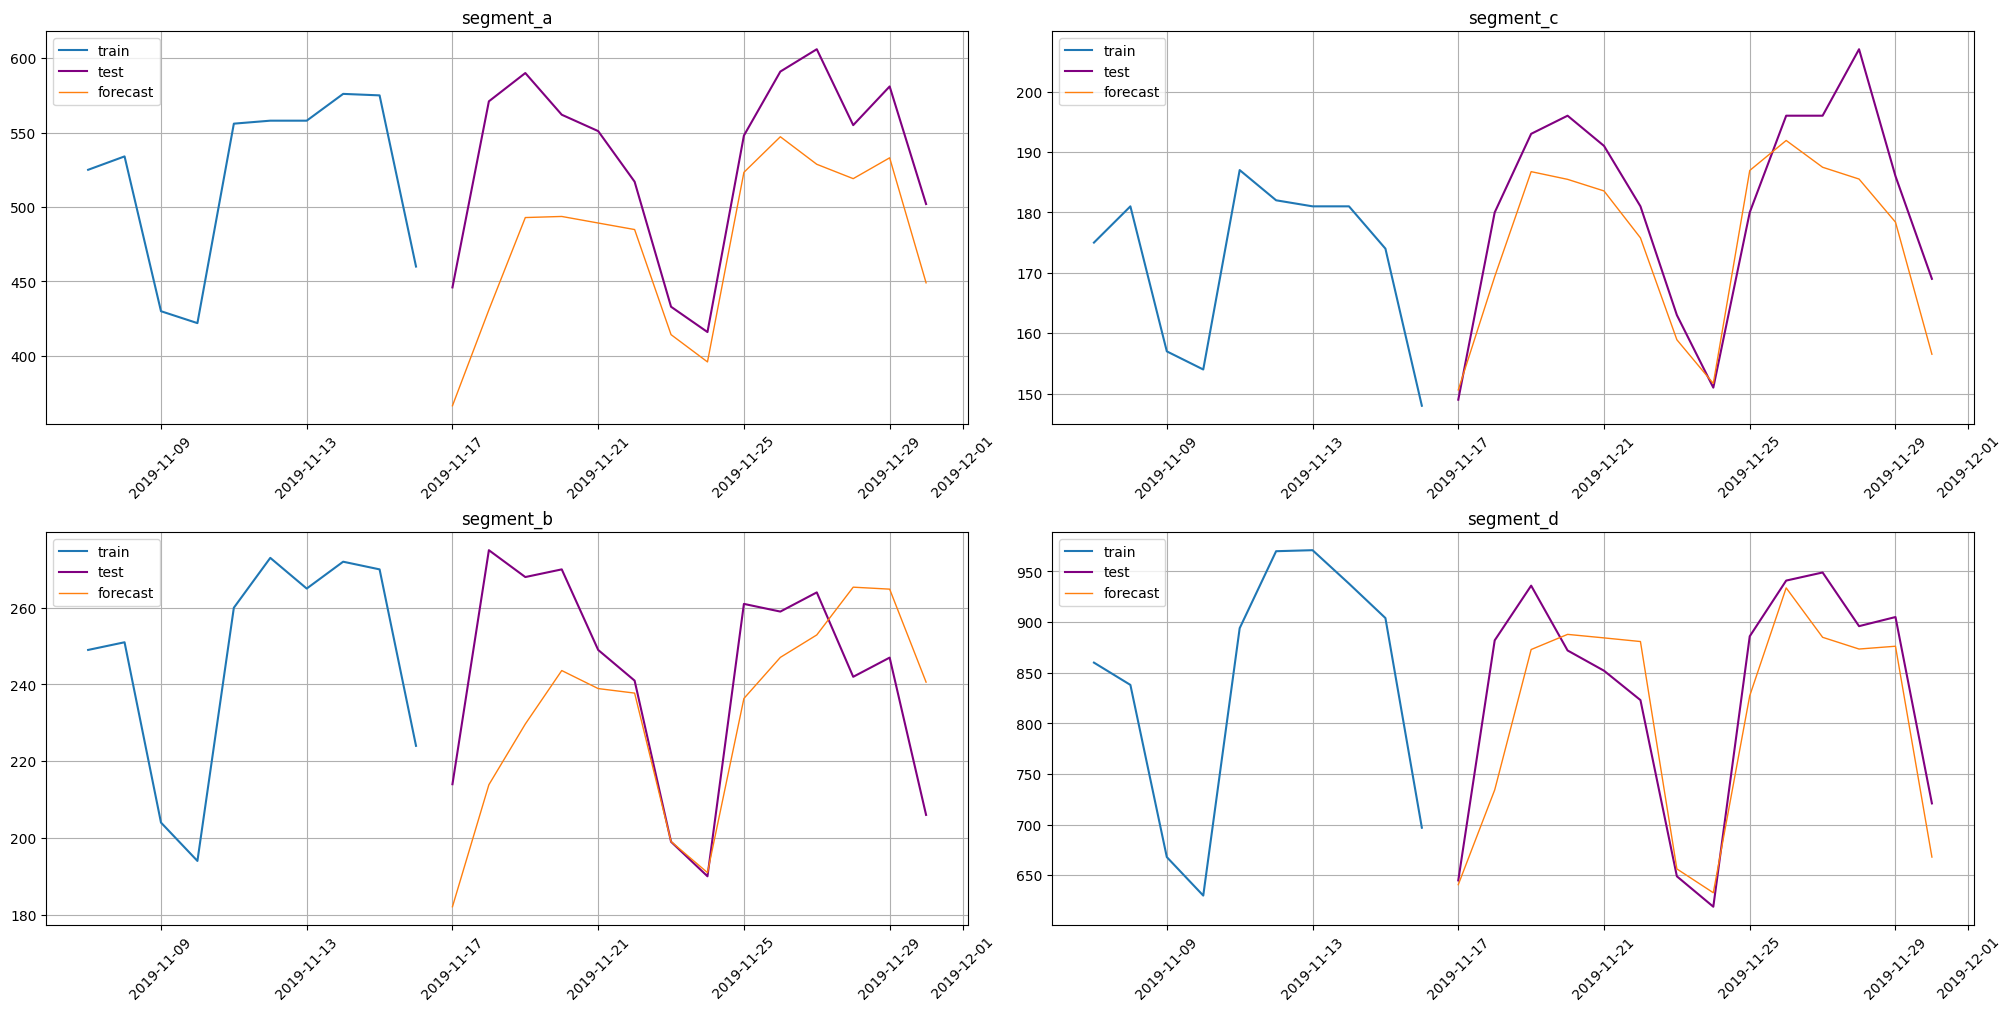

In [30]:
train_ts.inverse_transform(transforms)
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)